In [84]:
import operator

In [21]:
class Segment_Tree(object):
    def __init__(self, capacity, operation, init_value):
        assert(capacity > 0 and capacity & (capacity-1) == 0), "capacity must be positive and a power of 2."
        
        self.capacity = capacity
        self.operation = operation
        self.tree = [init_value for _ in range(2 * capacity)]
    
    def __setitem__(self, idx, val):
        idx += self.capacity
        self.tree[idx] = val
        
        idx //= 2
        while idx >= 1:
            self.tree[idx] = self.operation(self.tree[2 * idx], self.tree[2 * idx +1])
            idx //= 2
    
    def __getitem__(self, idx):
        
        assert 0 <= idx < self.capacity
        
        return self.tree[self.capacity + idx]        

In [77]:
class SumTree(Segment_Tree):
    def __init__(self, capacity):
        super(SumTree, self).__init__(capacity = capacity,
                                     operation = operator.add,
                                     init_value = 0.0)
    def sum(self):
        return self.tree[1]
    
    def retrieve(self, upperbound):
        assert 0 <= upperbound <= self.sum() + 1e-5, "upperbound: {}".format(upperbound)
        
        idx = 1
        
        while idx < self.capacity:
            left = 2 * idx
            right = left + 1
            if self.tree[left] < upperbound:
                upperbound -= self.tree[left]
                idx = right
            else:
                idx = left
        
        return idx - self.capacity

In [118]:
class MinTree(Segment_Tree):
    def __init__(self, capacity):
        super(MinTree, self).__init__(capacity = capacity,
                                     operation = min,
                                     init_value = float("inf"))
    def min(self):
        return self.tree[1]

In [101]:
sum_Tree = MinTree(8)

In [102]:
for i in range(8):
    sum_Tree[i] = i+1

In [103]:
sum_Tree[4] = -1

In [104]:

print(sum_Tree.tree[1])
print(sum_Tree.tree[2], sum_Tree.tree[3])
print(sum_Tree.tree[4], sum_Tree.tree[5], sum_Tree.tree[6], sum_Tree.tree[7])
print(sum_Tree.tree[8], sum_Tree.tree[9], sum_Tree.tree[10], sum_Tree.tree[11],
     sum_Tree.tree[12], sum_Tree.tree[13], sum_Tree.tree[14], sum_Tree.tree[15])

-1
1 -1
1 3 -1 7
1 2 3 4 -1 6 7 8


In [89]:
sum_Tree.retrieve(36.000000000001) + 1

8

In [83]:
import numpy as np

class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, buffer_size):  # Image state will be handled at ImageBuffer
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.buffer_size = buffer_size
        self.count = 0
        self.ptr = 0

        self.s_buffer = np.zeros([buffer_size, state_dim])
        self.a_buffer = np.zeros([buffer_size, action_dim])
        self.r_buffer = np.zeros([buffer_size, 1])
        self.t_buffer = np.zeros([buffer_size, 1])
        self.s2_buffer = np.zeros([buffer_size, state_dim])

    def size(self):
        return self.count

    def add(self, s, a, r, t, s2):
        assert s.shape == (self.state_dim,)
        assert a.shape == (self.action_dim,)
        assert r.shape == (1,)
        assert t.shape == (1,)
        assert s2.shape == (self.state_dim,)

        self.s_buffer[self.ptr] = s
        self.a_buffer[self.ptr] = a
        self.r_buffer[self.ptr] = r
        self.t_buffer[self.ptr] = t
        self.s2_buffer[self.ptr] = s2

        self.count = min(self.count + 1, self.buffer_size)
        self.ptr = (self.ptr + 1) % self.buffer_size

    def sample_batch(self, batch_size):
        batch_size = min(self.count, batch_size)

        sample_idx = np.random.choice(self.count, batch_size, replace=False)

        return self.s_buffer[sample_idx], self.a_buffer[sample_idx], self.r_buffer[sample_idx], self.t_buffer[
            sample_idx], self.s2_buffer[sample_idx]



In [128]:
class PERBuffer(ReplayBuffer):
    def __init__(self, state_dim, action_dim, buffer_size, alpha, initial_beta):
        super(PERBuffer, self).__init__(state_dim = state_dim,
                                       action_dim = action_dim,
                                       buffer_size = buffer_size)
        
        assert alpha > 0.0 and initial_beta > 0.0
        
        self.alpha = alpha
        self.initial_beta = initial_beta
        self.beta = self.initial_beta
        
        tree_capacity = 1
        while tree_capacity < self.buffer_size:
            tree_capacity *= 2
        
        self.sumTree = SumTree(tree_capacity)
        self.minTree = MinTree(tree_capacity)
        
        self.tree_ptr = 0
        
        self.max_priority = 1.0 # This is containg alpha inside
    
    def store(self, s, a, r, t, s2):
        self.add(s, a, r, t, s2)
        self.sumTree[self.tree_ptr] = self.max_priority
        self.minTree[self.tree_ptr] = self.max_priority
        self.tree_ptr = (self.tree_ptr + 1) % self.buffer_size
        
    def update_beta(self, current_step, final_step):
        self.beta = self.initial_beta + (1 - self.initial_beta) * current_step / final_step
    
    def sample_batch(self, batch_size):
        
        assert self.count >= batch_size
        
        indices = self._sample_proportional(batch_size)
        
        s = self.s_buffer[indices]
        a = self.a_buffer[indices]
        r = self.r_buffer[indices]
        t = self.t_buffer[indices]
        s2 = self.t_buffer[indices]
        weights = self._calculate_weights(indices)
        
        return s, a, r, t, s2, indices, weights
    
    def update_priorities(self, indices, td_errors):
        assert len(indices) == len(td_errors)
        
        for idx, td in zip(indices, td_errors):
            self.sumTree[idx] = td ** self.alpha
            self.minTree[idx] = td ** self.alpha
            
        self.max_priority = max(self.max_priority, max(td_errors) ** self.alpha)
        
    
    def _sample_proportional(self, batch_size):
        
        indices = []
        p_sum = self.sumTree.sum()
        upper_bounds = np.random.uniform(0.0, p_sum, batch_size)
        
        for ub in upper_bounds:
            indices.append(self.sumTree.retrieve(ub))
        
        return indices
    
    def _calculate_weights(self, indices):
        
        tree_min = self.minTree.min()
        
        weights = (tree_min / np.array([self.sumTree[idx] for idx in indices])) ** self.beta
        
        return weights

In [236]:
#state_dim, action_dim, buffer_size, alpha, initial_beta
per_buffer = PERBuffer(1,1,10,0.6,0.4)

In [237]:
for i in range(1,15):
    per_buffer.store(np.array([i]),
                np.array([i]),
                np.array([i]),
                np.array([True]),
                np.array([i+1]))

In [115]:
# s, a, r, t, s2, indices, weights

In [279]:
per_buffer.sample_batch(3)

(array([[ 6.],
        [13.],
        [10.]]), array([[ 6.],
        [13.],
        [10.]]), array([[ 6.],
        [13.],
        [10.]]), array([[1.],
        [1.],
        [1.]]), array([[1.],
        [1.],
        [1.]]), [5, 2, 9], array([1., 1., 1.]))

In [233]:
for i in range(0, 3):
    per_buffer.update_priorities(np.array([i]),np.array([0.1]))

In [280]:
test=[]
for _ in range(10000):
    test.append(per_buffer.sample_batch(1)[5][0])

In [182]:
import matplotlib.pyplot as plt

(array([ 980.,  991.,  962.,  996.,  979., 1013.,  968., 1041., 1023.,
        1047.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

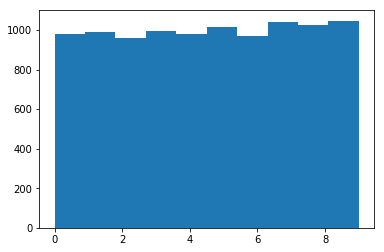

In [281]:
plt.hist(test)

In [282]:
import torch

In [297]:
a = torch.ones([32,16])
b = torch.ones([32]) * 2

In [290]:
a

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1

In [291]:
b

tensor([[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]])

In [285]:
a.shape, b.shape

(torch.Size([32, 16]), torch.Size([32, 1]))

In [292]:
(a+b).shape

torch.Size([32, 16])

In [299]:
torch.cat(3*[b],dim=1)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [385]:
np.random.uniform(0.0, 100000000, 32)

array([5.28938734e+26, 4.97940813e+27, 5.23016412e+27, 5.20305425e+27,
       1.25231764e+27, 4.68537644e+26, 1.23273485e+27, 5.52694996e+27,
       4.41570836e+27, 6.03753229e+27, 3.87496797e+27, 2.20851531e+27,
       6.54063301e+27, 6.77659646e+27, 2.64310056e+27, 7.01665700e+27,
       2.04060385e+27, 7.43301794e+27, 4.06269728e+27, 9.89606054e+27,
       8.74050496e+26, 8.35316936e+27, 6.97779274e+27, 5.03456040e+27,
       7.23683857e+27, 3.71732011e+27, 7.03077271e+27, 3.20419826e+27,
       3.32817414e+27, 4.60575851e+26, 4.04951439e+26, 7.84851987e+27])